In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    torchvision.transforms.Resize(14),
    transforms.ToTensor(),  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

img_res = images.shape[3]

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 14, 14])
Image label dimensions: torch.Size([64])


In [4]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.num_parameters = self.count_params(layers, grid_size)
        self.layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [5]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, img_res*img_res).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, img_res*img_res).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t      Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [6]:
def build_data_frame(model, num_epochs, train_losses, val_losses, train_accs, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [7]:
# Define models and parameters

model_list_mlp = [
    MyMLP([img_res*img_res, 128, 10]),
    MyMLP([img_res*img_res, 64, 10]),
    MyMLP([img_res*img_res, 10, 10]),
    MyMLP([img_res*img_res, 5, 10]),
    MyMLP([img_res*img_res, 10, 10, 10]),
    MyMLP([img_res*img_res, 5, 5, 10]),
    ]
model_list_kan = [
    MyKAN([img_res*img_res, 128, 10], grid_size=3),
    MyKAN([img_res*img_res, 64, 10], grid_size=3),
    MyKAN([img_res*img_res, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 10], grid_size=3),
    MyKAN([img_res*img_res, 10, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_mlp],
        'Loss (v)': [i for i in val_losses_mlp],
        'Accuracy (t)': [i for i in train_accs_mlp],
        'Accuracy (v)': [i for i in val_accs_mlp],
        'Time': [i for i in time_mlp]
        })

    single_df_kan = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses_kan],
        'Loss (v)': [i for i in val_losses_kan],
        'Accuracy (t)': [i for i in train_accs_kan],
        'Accuracy (v)': [i for i in val_accs_kan],
        'Time': [i for i in time_kan]
        })

    means_mlp = {'Epoch': 'Mean', 'Time': single_df_mlp['Time'].mean()}
    means_kan = {'Epoch': 'Mean', 'Time': single_df_kan['Time'].mean()}

    num_params_mlp = {'Epoch': f'Params: {model_mlp.num_parameters}'}
    num_params_kan = {'Epoch': f'Params: {model_kan.num_parameters}'}

    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([means_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, pd.DataFrame([num_params_mlp])], ignore_index=True)
    single_df_mlp = pd.concat([single_df_mlp, separator], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([means_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, pd.DataFrame([num_params_kan])], ignore_index=True)
    single_df_kan = pd.concat([single_df_kan, separator], ignore_index=True)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 26506



100%|██████████| 938/938 [00:08<00:00, 112.07it/s]


Epoch [1/10], Train Loss: 0.4952, Train Accuracy: 0.8625, Time: 8.37s
	      Valid Loss: 0.2977, Valid Accuracy: 0.9215



100%|██████████| 938/938 [00:07<00:00, 124.23it/s]


Epoch [2/10], Train Loss: 0.2666, Train Accuracy: 0.9215, Time: 7.55s
	      Valid Loss: 0.2099, Valid Accuracy: 0.9445



100%|██████████| 938/938 [00:07<00:00, 117.76it/s]


Epoch [3/10], Train Loss: 0.2005, Train Accuracy: 0.9423, Time: 7.97s
	      Valid Loss: 0.1758, Valid Accuracy: 0.9519



100%|██████████| 938/938 [00:07<00:00, 126.17it/s]


Epoch [4/10], Train Loss: 0.1610, Train Accuracy: 0.9538, Time: 7.44s
	      Valid Loss: 0.1325, Valid Accuracy: 0.9674



100%|██████████| 938/938 [00:07<00:00, 120.50it/s]


Epoch [5/10], Train Loss: 0.1375, Train Accuracy: 0.9607, Time: 7.79s
	      Valid Loss: 0.1327, Valid Accuracy: 0.9668



100%|██████████| 938/938 [00:07<00:00, 120.73it/s]


Epoch [6/10], Train Loss: 0.1211, Train Accuracy: 0.9653, Time: 7.77s
	      Valid Loss: 0.1151, Valid Accuracy: 0.9729



100%|██████████| 938/938 [00:07<00:00, 121.87it/s]


Epoch [7/10], Train Loss: 0.1100, Train Accuracy: 0.9683, Time: 7.70s
	      Valid Loss: 0.1068, Valid Accuracy: 0.9736



100%|██████████| 938/938 [00:07<00:00, 120.49it/s]


Epoch [8/10], Train Loss: 0.1000, Train Accuracy: 0.9704, Time: 7.79s
	      Valid Loss: 0.1032, Valid Accuracy: 0.9760



100%|██████████| 938/938 [00:07<00:00, 121.28it/s]


Epoch [9/10], Train Loss: 0.0925, Train Accuracy: 0.9726, Time: 7.74s
	      Valid Loss: 0.0998, Valid Accuracy: 0.9763



100%|██████████| 938/938 [00:07<00:00, 122.86it/s]


Epoch [10/10], Train Loss: 0.0861, Train Accuracy: 0.9743, Time: 7.64s
	      Valid Loss: 0.0904, Valid Accuracy: 0.9788

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 79104



100%|██████████| 938/938 [00:08<00:00, 109.49it/s]


Epoch [1/10], Train Loss: 0.4651, Train Accuracy: 0.8701, Time: 8.57s
	      Valid Loss: 0.2268, Valid Accuracy: 0.9401



100%|██████████| 938/938 [00:08<00:00, 107.11it/s]


Epoch [2/10], Train Loss: 0.1895, Train Accuracy: 0.9446, Time: 8.76s
	      Valid Loss: 0.1560, Valid Accuracy: 0.9593



100%|██████████| 938/938 [00:08<00:00, 108.82it/s]


Epoch [3/10], Train Loss: 0.1254, Train Accuracy: 0.9643, Time: 8.62s
	      Valid Loss: 0.1133, Valid Accuracy: 0.9732



100%|██████████| 938/938 [00:08<00:00, 110.44it/s]


Epoch [4/10], Train Loss: 0.0928, Train Accuracy: 0.9734, Time: 8.49s
	      Valid Loss: 0.0894, Valid Accuracy: 0.9777



100%|██████████| 938/938 [00:08<00:00, 107.81it/s]


Epoch [5/10], Train Loss: 0.0718, Train Accuracy: 0.9797, Time: 8.70s
	      Valid Loss: 0.0827, Valid Accuracy: 0.9794



100%|██████████| 938/938 [00:08<00:00, 105.17it/s]


Epoch [6/10], Train Loss: 0.0575, Train Accuracy: 0.9842, Time: 8.92s
	      Valid Loss: 0.0800, Valid Accuracy: 0.9812



100%|██████████| 938/938 [00:09<00:00, 102.64it/s]


Epoch [7/10], Train Loss: 0.0468, Train Accuracy: 0.9867, Time: 9.14s
	      Valid Loss: 0.0686, Valid Accuracy: 0.9843



100%|██████████| 938/938 [00:08<00:00, 105.93it/s]


Epoch [8/10], Train Loss: 0.0380, Train Accuracy: 0.9897, Time: 8.86s
	      Valid Loss: 0.0692, Valid Accuracy: 0.9836



100%|██████████| 938/938 [00:08<00:00, 105.06it/s]


Epoch [9/10], Train Loss: 0.0307, Train Accuracy: 0.9920, Time: 8.93s
	      Valid Loss: 0.0707, Valid Accuracy: 0.9850



100%|██████████| 938/938 [00:09<00:00, 102.47it/s]


Epoch [10/10], Train Loss: 0.0257, Train Accuracy: 0.9939, Time: 9.16s
	      Valid Loss: 0.0673, Valid Accuracy: 0.9861

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 13258



100%|██████████| 938/938 [00:07<00:00, 118.85it/s]


Epoch [1/10], Train Loss: 0.5599, Train Accuracy: 0.8487, Time: 7.89s
	      Valid Loss: 0.3191, Valid Accuracy: 0.9122



100%|██████████| 938/938 [00:08<00:00, 116.99it/s]


Epoch [2/10], Train Loss: 0.3094, Train Accuracy: 0.9109, Time: 8.02s
	      Valid Loss: 0.2647, Valid Accuracy: 0.9311



100%|██████████| 938/938 [00:07<00:00, 122.24it/s]


Epoch [3/10], Train Loss: 0.2566, Train Accuracy: 0.9260, Time: 7.67s
	      Valid Loss: 0.2222, Valid Accuracy: 0.9401



100%|██████████| 938/938 [00:07<00:00, 119.24it/s]


Epoch [4/10], Train Loss: 0.2183, Train Accuracy: 0.9367, Time: 7.87s
	      Valid Loss: 0.2087, Valid Accuracy: 0.9459



100%|██████████| 938/938 [00:07<00:00, 126.38it/s]


Epoch [5/10], Train Loss: 0.1929, Train Accuracy: 0.9440, Time: 7.42s
	      Valid Loss: 0.1725, Valid Accuracy: 0.9548



100%|██████████| 938/938 [00:07<00:00, 119.88it/s]


Epoch [6/10], Train Loss: 0.1709, Train Accuracy: 0.9513, Time: 7.83s
	      Valid Loss: 0.1526, Valid Accuracy: 0.9622



100%|██████████| 938/938 [00:07<00:00, 119.21it/s]


Epoch [7/10], Train Loss: 0.1532, Train Accuracy: 0.9559, Time: 7.87s
	      Valid Loss: 0.1401, Valid Accuracy: 0.9655



100%|██████████| 938/938 [00:07<00:00, 124.31it/s]


Epoch [8/10], Train Loss: 0.1416, Train Accuracy: 0.9594, Time: 7.55s
	      Valid Loss: 0.1294, Valid Accuracy: 0.9693



100%|██████████| 938/938 [00:07<00:00, 124.06it/s]


Epoch [9/10], Train Loss: 0.1315, Train Accuracy: 0.9623, Time: 7.56s
	      Valid Loss: 0.1236, Valid Accuracy: 0.9705



100%|██████████| 938/938 [00:07<00:00, 124.42it/s]


Epoch [10/10], Train Loss: 0.1232, Train Accuracy: 0.9641, Time: 7.54s
	      Valid Loss: 0.1237, Valid Accuracy: 0.9705

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 39552



100%|██████████| 938/938 [00:08<00:00, 109.00it/s]


Epoch [1/10], Train Loss: 0.5054, Train Accuracy: 0.8588, Time: 8.61s
	      Valid Loss: 0.2404, Valid Accuracy: 0.9374



100%|██████████| 938/938 [00:08<00:00, 108.16it/s]


Epoch [2/10], Train Loss: 0.2086, Train Accuracy: 0.9391, Time: 8.67s
	      Valid Loss: 0.1717, Valid Accuracy: 0.9563



100%|██████████| 938/938 [00:08<00:00, 106.64it/s]


Epoch [3/10], Train Loss: 0.1523, Train Accuracy: 0.9549, Time: 8.80s
	      Valid Loss: 0.1366, Valid Accuracy: 0.9673



100%|██████████| 938/938 [00:08<00:00, 110.25it/s]


Epoch [4/10], Train Loss: 0.1192, Train Accuracy: 0.9656, Time: 8.51s
	      Valid Loss: 0.1141, Valid Accuracy: 0.9727



100%|██████████| 938/938 [00:08<00:00, 107.47it/s]


Epoch [5/10], Train Loss: 0.0978, Train Accuracy: 0.9713, Time: 8.73s
	      Valid Loss: 0.1009, Valid Accuracy: 0.9769



100%|██████████| 938/938 [00:08<00:00, 106.24it/s]


Epoch [6/10], Train Loss: 0.0820, Train Accuracy: 0.9764, Time: 8.83s
	      Valid Loss: 0.0952, Valid Accuracy: 0.9781



100%|██████████| 938/938 [00:08<00:00, 107.26it/s]


Epoch [7/10], Train Loss: 0.0702, Train Accuracy: 0.9801, Time: 8.75s
	      Valid Loss: 0.0862, Valid Accuracy: 0.9795



100%|██████████| 938/938 [00:09<00:00, 102.29it/s]


Epoch [8/10], Train Loss: 0.0611, Train Accuracy: 0.9828, Time: 9.17s
	      Valid Loss: 0.0875, Valid Accuracy: 0.9794



100%|██████████| 938/938 [00:09<00:00, 103.37it/s]


Epoch [9/10], Train Loss: 0.0526, Train Accuracy: 0.9858, Time: 9.08s
	      Valid Loss: 0.0867, Valid Accuracy: 0.9811



100%|██████████| 938/938 [00:08<00:00, 108.87it/s]


Epoch [10/10], Train Loss: 0.0470, Train Accuracy: 0.9873, Time: 8.62s
	      Valid Loss: 0.0834, Valid Accuracy: 0.9804

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 2080



100%|██████████| 938/938 [00:07<00:00, 121.87it/s]


Epoch [1/10], Train Loss: 1.1275, Train Accuracy: 0.6425, Time: 7.70s
	      Valid Loss: 0.6401, Valid Accuracy: 0.8060



100%|██████████| 938/938 [00:07<00:00, 127.81it/s]


Epoch [2/10], Train Loss: 0.5797, Train Accuracy: 0.8244, Time: 7.34s
	      Valid Loss: 0.5042, Valid Accuracy: 0.8502



100%|██████████| 938/938 [00:07<00:00, 126.92it/s]


Epoch [3/10], Train Loss: 0.5002, Train Accuracy: 0.8507, Time: 7.39s
	      Valid Loss: 0.4601, Valid Accuracy: 0.8658



100%|██████████| 938/938 [00:07<00:00, 121.98it/s]


Epoch [4/10], Train Loss: 0.4690, Train Accuracy: 0.8620, Time: 7.69s
	      Valid Loss: 0.4372, Valid Accuracy: 0.8732



100%|██████████| 938/938 [00:07<00:00, 120.59it/s]


Epoch [5/10], Train Loss: 0.4502, Train Accuracy: 0.8684, Time: 7.78s
	      Valid Loss: 0.4262, Valid Accuracy: 0.8768



100%|██████████| 938/938 [00:07<00:00, 120.93it/s]


Epoch [6/10], Train Loss: 0.4375, Train Accuracy: 0.8723, Time: 7.76s
	      Valid Loss: 0.4162, Valid Accuracy: 0.8820



100%|██████████| 938/938 [00:07<00:00, 120.94it/s]


Epoch [7/10], Train Loss: 0.4287, Train Accuracy: 0.8752, Time: 7.76s
	      Valid Loss: 0.4118, Valid Accuracy: 0.8836



100%|██████████| 938/938 [00:07<00:00, 122.55it/s]


Epoch [8/10], Train Loss: 0.4217, Train Accuracy: 0.8770, Time: 7.66s
	      Valid Loss: 0.4022, Valid Accuracy: 0.8888



100%|██████████| 938/938 [00:07<00:00, 122.30it/s]


Epoch [9/10], Train Loss: 0.4173, Train Accuracy: 0.8775, Time: 7.67s
	      Valid Loss: 0.4016, Valid Accuracy: 0.8882



100%|██████████| 938/938 [00:07<00:00, 119.91it/s]


Epoch [10/10], Train Loss: 0.4117, Train Accuracy: 0.8801, Time: 7.82s
	      Valid Loss: 0.3986, Valid Accuracy: 0.8864

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 6180



100%|██████████| 938/938 [00:09<00:00, 103.93it/s]


Epoch [1/10], Train Loss: 0.7514, Train Accuracy: 0.7832, Time: 9.03s
	      Valid Loss: 0.3295, Valid Accuracy: 0.9111



100%|██████████| 938/938 [00:08<00:00, 107.79it/s]


Epoch [2/10], Train Loss: 0.2914, Train Accuracy: 0.9176, Time: 8.70s
	      Valid Loss: 0.2643, Valid Accuracy: 0.9288



100%|██████████| 938/938 [00:08<00:00, 106.87it/s]


Epoch [3/10], Train Loss: 0.2454, Train Accuracy: 0.9284, Time: 8.78s
	      Valid Loss: 0.2334, Valid Accuracy: 0.9416



100%|██████████| 938/938 [00:08<00:00, 109.95it/s]


Epoch [4/10], Train Loss: 0.2184, Train Accuracy: 0.9362, Time: 8.53s
	      Valid Loss: 0.2126, Valid Accuracy: 0.9448



100%|██████████| 938/938 [00:08<00:00, 108.11it/s]


Epoch [5/10], Train Loss: 0.2018, Train Accuracy: 0.9410, Time: 8.68s
	      Valid Loss: 0.1973, Valid Accuracy: 0.9489



100%|██████████| 938/938 [00:08<00:00, 109.18it/s]


Epoch [6/10], Train Loss: 0.1894, Train Accuracy: 0.9450, Time: 8.59s
	      Valid Loss: 0.1942, Valid Accuracy: 0.9479



100%|██████████| 938/938 [00:08<00:00, 104.46it/s]


Epoch [7/10], Train Loss: 0.1796, Train Accuracy: 0.9475, Time: 8.98s
	      Valid Loss: 0.1867, Valid Accuracy: 0.9512



100%|██████████| 938/938 [00:09<00:00, 103.18it/s]


Epoch [8/10], Train Loss: 0.1720, Train Accuracy: 0.9494, Time: 9.09s
	      Valid Loss: 0.1836, Valid Accuracy: 0.9528



100%|██████████| 938/938 [00:09<00:00, 101.14it/s]


Epoch [9/10], Train Loss: 0.1649, Train Accuracy: 0.9519, Time: 9.28s
	      Valid Loss: 0.1798, Valid Accuracy: 0.9539



100%|██████████| 938/938 [00:09<00:00, 103.62it/s]


Epoch [10/10], Train Loss: 0.1606, Train Accuracy: 0.9526, Time: 9.05s
	      Valid Loss: 0.1748, Valid Accuracy: 0.9546

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 1045



100%|██████████| 938/938 [00:07<00:00, 119.86it/s]


Epoch [1/10], Train Loss: 1.5489, Train Accuracy: 0.4522, Time: 7.83s
	      Valid Loss: 1.1642, Valid Accuracy: 0.6364



100%|██████████| 938/938 [00:07<00:00, 118.64it/s]


Epoch [2/10], Train Loss: 1.0414, Train Accuracy: 0.6643, Time: 7.91s
	      Valid Loss: 0.9421, Valid Accuracy: 0.6963



100%|██████████| 938/938 [00:07<00:00, 120.14it/s]


Epoch [3/10], Train Loss: 0.9101, Train Accuracy: 0.6979, Time: 7.81s
	      Valid Loss: 0.8634, Valid Accuracy: 0.7180



100%|██████████| 938/938 [00:07<00:00, 118.87it/s]


Epoch [4/10], Train Loss: 0.8528, Train Accuracy: 0.7148, Time: 7.89s
	      Valid Loss: 0.8203, Valid Accuracy: 0.7299



100%|██████████| 938/938 [00:07<00:00, 119.17it/s]


Epoch [5/10], Train Loss: 0.8214, Train Accuracy: 0.7252, Time: 7.87s
	      Valid Loss: 0.8008, Valid Accuracy: 0.7379



100%|██████████| 938/938 [00:07<00:00, 118.97it/s]


Epoch [6/10], Train Loss: 0.7990, Train Accuracy: 0.7373, Time: 7.89s
	      Valid Loss: 0.7790, Valid Accuracy: 0.7526



100%|██████████| 938/938 [00:07<00:00, 119.42it/s]


Epoch [7/10], Train Loss: 0.7819, Train Accuracy: 0.7476, Time: 7.86s
	      Valid Loss: 0.7660, Valid Accuracy: 0.7566



100%|██████████| 938/938 [00:07<00:00, 119.93it/s]


Epoch [8/10], Train Loss: 0.7679, Train Accuracy: 0.7555, Time: 7.82s
	      Valid Loss: 0.7496, Valid Accuracy: 0.7728



100%|██████████| 938/938 [00:07<00:00, 118.83it/s]


Epoch [9/10], Train Loss: 0.7540, Train Accuracy: 0.7645, Time: 7.90s
	      Valid Loss: 0.7376, Valid Accuracy: 0.7818



100%|██████████| 938/938 [00:07<00:00, 120.40it/s]


Epoch [10/10], Train Loss: 0.7414, Train Accuracy: 0.7699, Time: 7.79s
	      Valid Loss: 0.7277, Valid Accuracy: 0.7849

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3090



100%|██████████| 938/938 [00:09<00:00, 104.18it/s]


Epoch [1/10], Train Loss: 1.0485, Train Accuracy: 0.7025, Time: 9.00s
	      Valid Loss: 0.5043, Valid Accuracy: 0.8751



100%|██████████| 938/938 [00:08<00:00, 106.04it/s]


Epoch [2/10], Train Loss: 0.4381, Train Accuracy: 0.8802, Time: 8.85s
	      Valid Loss: 0.3774, Valid Accuracy: 0.9038



100%|██████████| 938/938 [00:08<00:00, 105.97it/s]


Epoch [3/10], Train Loss: 0.3630, Train Accuracy: 0.8983, Time: 8.85s
	      Valid Loss: 0.3397, Valid Accuracy: 0.9126



100%|██████████| 938/938 [00:09<00:00, 104.05it/s]


Epoch [4/10], Train Loss: 0.3288, Train Accuracy: 0.9065, Time: 9.02s
	      Valid Loss: 0.3156, Valid Accuracy: 0.9172



100%|██████████| 938/938 [00:08<00:00, 108.08it/s]


Epoch [5/10], Train Loss: 0.3066, Train Accuracy: 0.9125, Time: 8.68s
	      Valid Loss: 0.3061, Valid Accuracy: 0.9196



100%|██████████| 938/938 [00:08<00:00, 108.92it/s]


Epoch [6/10], Train Loss: 0.2918, Train Accuracy: 0.9159, Time: 8.61s
	      Valid Loss: 0.3087, Valid Accuracy: 0.9187



100%|██████████| 938/938 [00:08<00:00, 104.65it/s]


Epoch [7/10], Train Loss: 0.2810, Train Accuracy: 0.9193, Time: 8.96s
	      Valid Loss: 0.2920, Valid Accuracy: 0.9233



100%|██████████| 938/938 [00:09<00:00, 104.06it/s]


Epoch [8/10], Train Loss: 0.2705, Train Accuracy: 0.9220, Time: 9.02s
	      Valid Loss: 0.2778, Valid Accuracy: 0.9290



100%|██████████| 938/938 [00:08<00:00, 105.91it/s]


Epoch [9/10], Train Loss: 0.2627, Train Accuracy: 0.9246, Time: 8.86s
	      Valid Loss: 0.2818, Valid Accuracy: 0.9285



100%|██████████| 938/938 [00:08<00:00, 107.96it/s]


Epoch [10/10], Train Loss: 0.2568, Train Accuracy: 0.9262, Time: 8.69s
	      Valid Loss: 0.2658, Valid Accuracy: 0.9315

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 2190



100%|██████████| 938/938 [00:07<00:00, 125.61it/s]


Epoch [1/10], Train Loss: 1.0550, Train Accuracy: 0.6567, Time: 7.47s
	      Valid Loss: 0.5796, Valid Accuracy: 0.8330



100%|██████████| 938/938 [00:07<00:00, 119.26it/s]


Epoch [2/10], Train Loss: 0.5039, Train Accuracy: 0.8531, Time: 7.87s
	      Valid Loss: 0.4324, Valid Accuracy: 0.8780



100%|██████████| 938/938 [00:07<00:00, 120.26it/s]


Epoch [3/10], Train Loss: 0.4327, Train Accuracy: 0.8764, Time: 7.80s
	      Valid Loss: 0.4040, Valid Accuracy: 0.8919



100%|██████████| 938/938 [00:07<00:00, 120.64it/s]


Epoch [4/10], Train Loss: 0.4041, Train Accuracy: 0.8847, Time: 7.78s
	      Valid Loss: 0.3775, Valid Accuracy: 0.8961



100%|██████████| 938/938 [00:07<00:00, 123.22it/s]


Epoch [5/10], Train Loss: 0.3853, Train Accuracy: 0.8900, Time: 7.61s
	      Valid Loss: 0.3694, Valid Accuracy: 0.9002



100%|██████████| 938/938 [00:07<00:00, 118.17it/s]


Epoch [6/10], Train Loss: 0.3712, Train Accuracy: 0.8935, Time: 7.94s
	      Valid Loss: 0.3550, Valid Accuracy: 0.9055



100%|██████████| 938/938 [00:07<00:00, 123.35it/s]


Epoch [7/10], Train Loss: 0.3610, Train Accuracy: 0.8960, Time: 7.61s
	      Valid Loss: 0.3391, Valid Accuracy: 0.9097



100%|██████████| 938/938 [00:07<00:00, 119.43it/s]


Epoch [8/10], Train Loss: 0.3528, Train Accuracy: 0.8987, Time: 7.86s
	      Valid Loss: 0.3495, Valid Accuracy: 0.9047



100%|██████████| 938/938 [00:07<00:00, 118.21it/s]


Epoch [9/10], Train Loss: 0.3490, Train Accuracy: 0.8991, Time: 7.94s
	      Valid Loss: 0.3397, Valid Accuracy: 0.9101



100%|██████████| 938/938 [00:07<00:00, 120.63it/s]


Epoch [10/10], Train Loss: 0.3413, Train Accuracy: 0.9009, Time: 7.78s
	      Valid Loss: 0.3325, Valid Accuracy: 0.9104

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 6480



100%|██████████| 938/938 [00:09<00:00, 95.62it/s]


Epoch [1/10], Train Loss: 0.8277, Train Accuracy: 0.7373, Time: 9.81s
	      Valid Loss: 0.3529, Valid Accuracy: 0.9073



100%|██████████| 938/938 [00:09<00:00, 94.52it/s]


Epoch [2/10], Train Loss: 0.3135, Train Accuracy: 0.9105, Time: 9.92s
	      Valid Loss: 0.2657, Valid Accuracy: 0.9293



100%|██████████| 938/938 [00:09<00:00, 97.46it/s]


Epoch [3/10], Train Loss: 0.2520, Train Accuracy: 0.9267, Time: 9.63s
	      Valid Loss: 0.2409, Valid Accuracy: 0.9366



100%|██████████| 938/938 [00:09<00:00, 95.17it/s]


Epoch [4/10], Train Loss: 0.2211, Train Accuracy: 0.9349, Time: 9.86s
	      Valid Loss: 0.2114, Valid Accuracy: 0.9445



100%|██████████| 938/938 [00:09<00:00, 95.59it/s]


Epoch [5/10], Train Loss: 0.2016, Train Accuracy: 0.9407, Time: 9.81s
	      Valid Loss: 0.2056, Valid Accuracy: 0.9462



100%|██████████| 938/938 [00:09<00:00, 94.14it/s]


Epoch [6/10], Train Loss: 0.1882, Train Accuracy: 0.9451, Time: 9.96s
	      Valid Loss: 0.1948, Valid Accuracy: 0.9490



100%|██████████| 938/938 [00:09<00:00, 99.04it/s]


Epoch [7/10], Train Loss: 0.1769, Train Accuracy: 0.9477, Time: 9.47s
	      Valid Loss: 0.1847, Valid Accuracy: 0.9522



100%|██████████| 938/938 [00:10<00:00, 93.35it/s]


Epoch [8/10], Train Loss: 0.1676, Train Accuracy: 0.9510, Time: 10.05s
	      Valid Loss: 0.1770, Valid Accuracy: 0.9559



100%|██████████| 938/938 [00:09<00:00, 94.48it/s]


Epoch [9/10], Train Loss: 0.1594, Train Accuracy: 0.9533, Time: 9.93s
	      Valid Loss: 0.1776, Valid Accuracy: 0.9546



100%|██████████| 938/938 [00:09<00:00, 95.76it/s]


Epoch [10/10], Train Loss: 0.1522, Train Accuracy: 0.9554, Time: 9.80s
	      Valid Loss: 0.1780, Valid Accuracy: 0.9546

Training model "MyMLP" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 1075



100%|██████████| 938/938 [00:08<00:00, 116.33it/s]


Epoch [1/10], Train Loss: 1.2953, Train Accuracy: 0.5591, Time: 8.06s
	      Valid Loss: 0.8872, Valid Accuracy: 0.7162



100%|██████████| 938/938 [00:08<00:00, 116.25it/s]


Epoch [2/10], Train Loss: 0.6983, Train Accuracy: 0.7838, Time: 8.07s
	      Valid Loss: 0.5943, Valid Accuracy: 0.8263



100%|██████████| 938/938 [00:08<00:00, 115.70it/s]


Epoch [3/10], Train Loss: 0.5644, Train Accuracy: 0.8312, Time: 8.11s
	      Valid Loss: 0.5286, Valid Accuracy: 0.8481



100%|██████████| 938/938 [00:07<00:00, 119.42it/s]


Epoch [4/10], Train Loss: 0.5215, Train Accuracy: 0.8470, Time: 7.86s
	      Valid Loss: 0.4990, Valid Accuracy: 0.8590



100%|██████████| 938/938 [00:07<00:00, 123.01it/s]


Epoch [5/10], Train Loss: 0.4921, Train Accuracy: 0.8568, Time: 7.63s
	      Valid Loss: 0.4738, Valid Accuracy: 0.8686



100%|██████████| 938/938 [00:07<00:00, 124.48it/s]


Epoch [6/10], Train Loss: 0.4723, Train Accuracy: 0.8636, Time: 7.54s
	      Valid Loss: 0.4674, Valid Accuracy: 0.8751



100%|██████████| 938/938 [00:07<00:00, 124.57it/s]


Epoch [7/10], Train Loss: 0.4579, Train Accuracy: 0.8679, Time: 7.53s
	      Valid Loss: 0.4472, Valid Accuracy: 0.8805



100%|██████████| 938/938 [00:07<00:00, 123.22it/s]


Epoch [8/10], Train Loss: 0.4470, Train Accuracy: 0.8734, Time: 7.61s
	      Valid Loss: 0.4680, Valid Accuracy: 0.8663



100%|██████████| 938/938 [00:07<00:00, 118.17it/s]


Epoch [9/10], Train Loss: 0.4389, Train Accuracy: 0.8747, Time: 7.94s
	      Valid Loss: 0.4480, Valid Accuracy: 0.8778



100%|██████████| 938/938 [00:08<00:00, 116.43it/s]


Epoch [10/10], Train Loss: 0.4316, Train Accuracy: 0.8767, Time: 8.06s
	      Valid Loss: 0.4241, Valid Accuracy: 0.8850

Training model "MyKAN" with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3165



100%|██████████| 938/938 [00:09<00:00, 99.10it/s]


Epoch [1/10], Train Loss: 1.2632, Train Accuracy: 0.5888, Time: 9.47s
	      Valid Loss: 0.6166, Valid Accuracy: 0.8291



100%|██████████| 938/938 [00:09<00:00, 98.93it/s]


Epoch [2/10], Train Loss: 0.5170, Train Accuracy: 0.8500, Time: 9.48s
	      Valid Loss: 0.4404, Valid Accuracy: 0.8767



100%|██████████| 938/938 [00:09<00:00, 98.23it/s]


Epoch [3/10], Train Loss: 0.4167, Train Accuracy: 0.8790, Time: 9.55s
	      Valid Loss: 0.3810, Valid Accuracy: 0.8947



100%|██████████| 938/938 [00:09<00:00, 98.98it/s]


Epoch [4/10], Train Loss: 0.3732, Train Accuracy: 0.8910, Time: 9.48s
	      Valid Loss: 0.3518, Valid Accuracy: 0.9054



100%|██████████| 938/938 [00:09<00:00, 99.49it/s]


Epoch [5/10], Train Loss: 0.3414, Train Accuracy: 0.9004, Time: 9.43s
	      Valid Loss: 0.3297, Valid Accuracy: 0.9091



100%|██████████| 938/938 [00:09<00:00, 95.99it/s]


Epoch [6/10], Train Loss: 0.3166, Train Accuracy: 0.9069, Time: 9.77s
	      Valid Loss: 0.3062, Valid Accuracy: 0.9169



100%|██████████| 938/938 [00:09<00:00, 94.24it/s]


Epoch [7/10], Train Loss: 0.2960, Train Accuracy: 0.9139, Time: 9.95s
	      Valid Loss: 0.2839, Valid Accuracy: 0.9235



100%|██████████| 938/938 [00:09<00:00, 96.48it/s]


Epoch [8/10], Train Loss: 0.2789, Train Accuracy: 0.9189, Time: 9.72s
	      Valid Loss: 0.2844, Valid Accuracy: 0.9223



100%|██████████| 938/938 [00:09<00:00, 97.23it/s]


Epoch [9/10], Train Loss: 0.2684, Train Accuracy: 0.9216, Time: 9.65s
	      Valid Loss: 0.2671, Valid Accuracy: 0.9265



100%|██████████| 938/938 [00:09<00:00, 96.49it/s]


Epoch [10/10], Train Loss: 0.2583, Train Accuracy: 0.9241, Time: 9.72s
	      Valid Loss: 0.2667, Valid Accuracy: 0.9270



In [8]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_7212/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


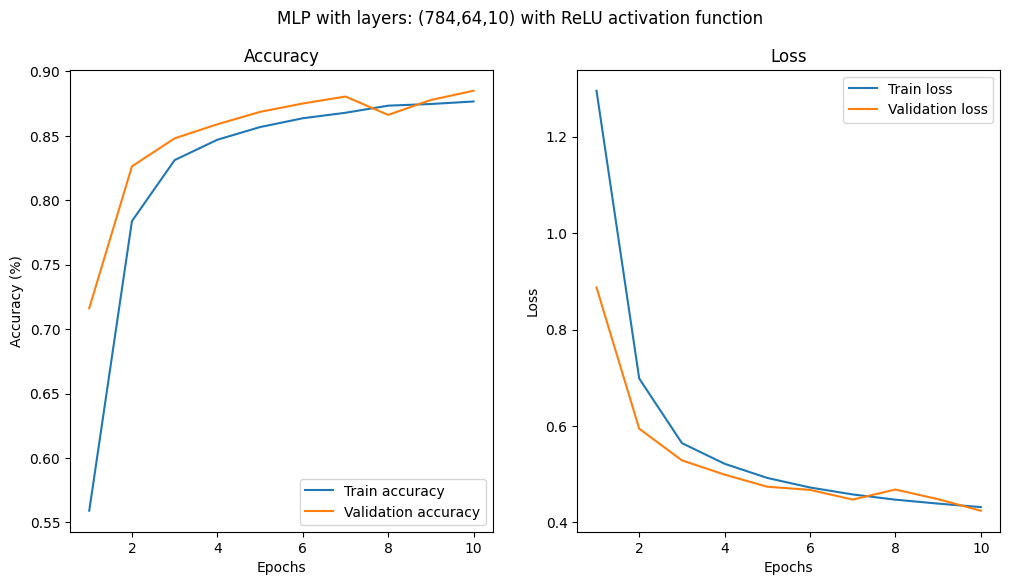

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_7212/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


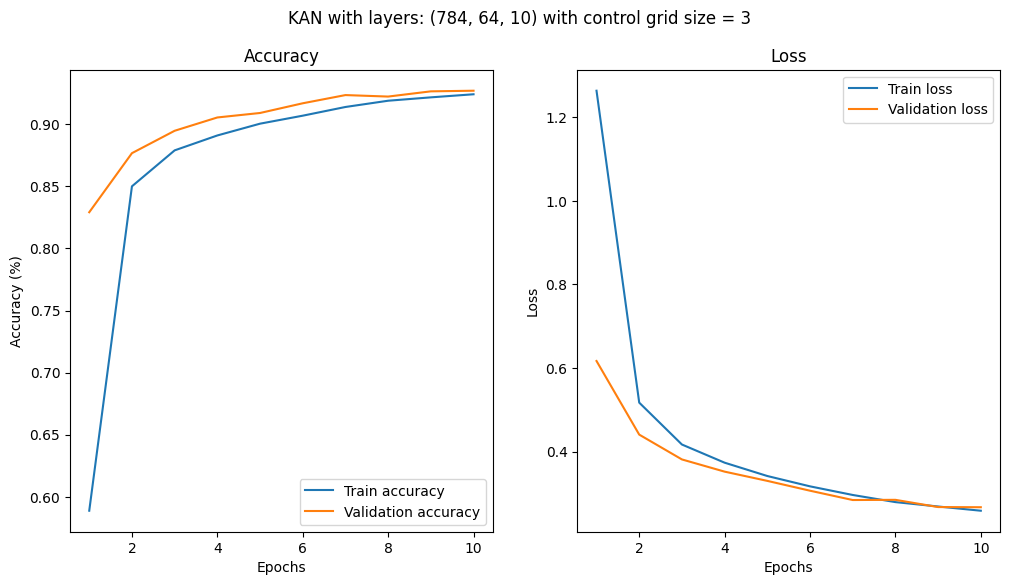

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()